#### To run this, install lxml.     how(windows): pip install lxml

In [1]:
!pip install lxml

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import os, csv
import requests
import pandas as pd
from scipy import stats
list=[]
#Web scraping.
# Quebec and Ontario only because North/West has one more column, will be done separately

# Going through 4th, 5th link on url
a=[4,5]

# list to store each dataframes
df_list = []

for x in a:
    url = f"https://internatlibs.mcgill.ca/hospitals/hospital-histories{x}.htm"
    data = requests.get(url).content

    # Scrapping all data from url    
    query = pd.read_html(data)
    
    # Getting 4th section which is the table into a dataframe. drop details
    df = pd.DataFrame(query[4]).drop(columns=[2])
    
    # rename column names and delete first row.
    df = df.rename(columns={0:"City", 1:"Hospital"})
    
    # delete first row and drop duplicate hospitals
    df = df.drop(df.index[0]).drop_duplicates(keep="first")
    
    # getting df with number of hospitals for each city, append it to list
    #  0th item is number of hospitals for each city of Quebec
    num_hos= df.groupby(["City"]).count().sort_values(by="Hospital", ascending=False)
    df_list.append(num_hos)

In [3]:
# Number of Hospitals for Quebec
num_hos_qb = df_list[0]
# get City back to column instead of index
num_hos_qb = num_hos_qb.reset_index()

# concat province 
num_hos_qb["City"] =num_hos_qb["City"] + ", Quebec"

display(num_hos_qb.head())


# number of hospitals for Ontario
num_hos_on = df_list[1]
num_hos_on = num_hos_on.reset_index()
num_hos_on["City"] = num_hos_on["City"] + ", Ontario"
display(num_hos_on.head())

,City,Hospital
0,"Montréal, Quebec",59
1,"Québec, Quebec",17
2,"Sherbrooke, Quebec",8
3,"Lévis, Quebec",3
4,"Rouyn-Noranda, Quebec",3


,City,Hospital
0,"Toronto, Ontario",42
1,"Hamilton, Ontario",14
2,"London, Ontario",10
3,"Ottawa, Ontario",10
4,"Thunder Bay, Ontario",7


### West and North

In [4]:
url = f"https://internatlibs.mcgill.ca/hospitals/hospital-histories6.htm"
data = requests.get(url).content
query = pd.read_html(data)

# Getting the table. this time it is 5th section, drop 1st row and details
df = pd.DataFrame(query[5]).drop(index=[0],columns=[3])

df = df.rename(columns={0:"Province", 1: "City", 2:"Hospital"})
# capitalize only first letter in 0 column
df["Province"] = df["Province"].str.title()


# merge City to Province. ex: Barrie, Ontario
df['Cities'] = df[['City','Province']].apply(lambda x: ', '.join(x.fillna('').map(str)), axis=1)
df = df.drop(columns=["Province", "City"])
df = df.rename(columns={"Cities":"City"})

# Change the order and drop duplicate hospitals
df = df[["City", "Hospital"]].drop_duplicates(keep="first")

# number of hospitals in each city.
num_hos_nw = df.groupby(["City"]).count().sort_values(by="Hospital", ascending=False)

display(num_hos_nw.head())

,Hospital
City,
"Winnipeg, Manitoba",17
"Edmonton, Alberta",13
"Calgary, Alberta",11
"Vancouver, British Columbia",10
"Victoria, British Columbia",7


In [5]:
# Merging Number of Hospitals for Quebec and number of hospitals for Ontario
merge_qb_on = pd.merge(num_hos_qb, num_hos_on,how='outer',on='City')
merge_qb_on["Hospital_x"] = merge_qb_on["Hospital_x"].fillna(0)
merge_qb_on["Hospital_y"] = merge_qb_on["Hospital_y"].fillna(0)
merge_qb_on.head()

,City,Hospital_x,Hospital_y
0,"Montréal, Quebec",59.0,0.0
1,"Québec, Quebec",17.0,0.0
2,"Sherbrooke, Quebec",8.0,0.0
3,"Lévis, Quebec",3.0,0.0
4,"Rouyn-Noranda, Quebec",3.0,0.0


In [6]:
# Merging Number of Hospitals for Quebec and Ontario and number of hospitals for North and West
merge_qb_on_nw = pd.merge(merge_qb_on, num_hos_nw,how='outer',on='City')
merge_qb_on_nw["Hospital_x"] = merge_qb_on_nw["Hospital_x"].fillna(0).astype(int)
merge_qb_on_nw["Hospital_y"] = merge_qb_on_nw["Hospital_y"].fillna(0).astype(int)
merge_qb_on_nw["Hospital"] = merge_qb_on_nw["Hospital"].fillna(0).astype(int)
merge_qb_on_nw.head()

,City,Hospital_x,Hospital_y,Hospital
0,"Montréal, Quebec",59,0,0
1,"Québec, Quebec",17,0,0
2,"Sherbrooke, Quebec",8,0,0
3,"Lévis, Quebec",3,0,0
4,"Rouyn-Noranda, Quebec",3,0,0


In [7]:
#Adding Total number of hospitals cities wise
merge_qb_on_nw["Hospitals"] = merge_qb_on_nw["Hospital_x"] + merge_qb_on_nw["Hospital_y"] + merge_qb_on_nw["Hospital"]


In [8]:
# deleting the unwanted hospitals columns and creating new summary dataframe of all the cities and number of hospitals
merged_summary= merge_qb_on_nw.drop(['Hospital_x', 'Hospital_y','Hospital'], axis=1)
# sort it alphabatically
merged_summary = merged_summary.sort_values(by=["City"]).reset_index(drop=True)
#displaying the merged file
merged_summary.head()
# From DataFrame to CSV (we modified the csv in next step)
#hospital_cities = merged_summary.to_csv("hospital_cities.csv")

,City,Hospitals
0,"Alma, Quebec",1
1,"Almonte, Ontario",1
2,"Altona, Manitoba",1
3,"Amqui, Quebec",1
4,"Argyle, Manitoba",1


In [9]:
### Done some modification for hospital_cities.csv by comparing google maps and "https://internatlibs.mcgill.ca/hospitals/hospital-histories"

In [10]:
#reading 2015 mortality csv
Data_2015_df = pd.read_csv("Hospital_Data/merged_1.csv")
Hospitals_cma_df = pd.read_csv("Hospital_Data/Hospital_CMA_Details.csv")
#Data_2015_df
Cities_2015_Hospital_df = pd.merge(Data_2015_df, Hospitals_cma_df,how='outer',on='Geography')
#Cities_2015_Hospital_df
Cities_2015_Hospital_df = Cities_2015_Hospital_df.drop(columns= ["Unnamed: 0_x"])
Cities_2015_Hospital_df = Cities_2015_Hospital_df.drop(columns= ["Unnamed: 0_y"])
Cities_2015_Hospital_df.head().fillna(0)
# From DataFrame to CSV 
Cities_2015_Hospital = Cities_2015_Hospital_df.to_csv("Hospital_Data/hospital_cities.csv")

In [11]:
Cities_2015_Hospital_df.head()

,Geography,population,Number of Mortality,Mortality Rate,Median Income,obesity rate by bmi,overweight rate by bmi,within 12 months seeing doctor,daily smoker,has regular healthprovider,Heavy drinking,life satisfection,Mood disorder,Poor perceived health,"Perceived life stress, high daily stress",poor perceived mental health,Physical activity 150 minutes per week,Hospitals
0,"Abbotsford-Mission, British Columbia",184021,1252,0.680357,30290,23.747290,23.747290,62.547209,12.770282,67.166247,13.422381,75.806566,9.727151,7.933877,18.965227,5.868895,48.744437,1
1,"Barrie, Ontario",202264,1426,0.705019,35270,21.457106,21.704307,56.361982,16.068109,72.479532,16.216430,70.056955,11.124075,11.025195,22.149270,6.625005,43.655816,1
2,"Brantford, Ontario",144109,1339,0.929158,33010,17.972507,24.564739,56.207454,17.625547,70.085838,17.070412,72.028812,9.090341,9.992436,14.086559,5.551353,41.704543,2
3,"Calgary, Alberta",1432169,6655,0.464680,43130,18.314878,28.858326,63.770407,11.709512,70.955313,15.235632,78.314780,6.528559,7.589886,18.517368,5.753511,47.648008,11
4,"Edmonton, Alberta",1358345,8173,0.601688,43190,19.509035,28.998524,62.038731,16.306608,67.192061,15.761828,77.601787,7.869871,8.429375,17.764265,5.447806,44.981209,13


In [12]:
#Reorganising the final dataframe
Final_Hospital_CMA_df = Cities_2015_Hospital_df[["Geography", "population", "Hospitals","Median Income", "Poor perceived health", "Perceived life stress, high daily stress", "poor perceived mental health" ,"has regular healthprovider", "Mortality Rate" ]]

Final_Hospital_CMA_df.head()


,Geography,population,Hospitals,Median Income,Poor perceived health,"Perceived life stress, high daily stress",poor perceived mental health,has regular healthprovider,Mortality Rate
0,"Abbotsford-Mission, British Columbia",184021,1,30290,7.933877,18.965227,5.868895,67.166247,0.680357
1,"Barrie, Ontario",202264,1,35270,11.025195,22.149270,6.625005,72.479532,0.705019
2,"Brantford, Ontario",144109,2,33010,9.992436,14.086559,5.551353,70.085838,0.929158
3,"Calgary, Alberta",1432169,11,43130,7.589886,18.517368,5.753511,70.955313,0.464680
4,"Edmonton, Alberta",1358345,13,43190,8.429375,17.764265,5.447806,67.192061,0.601688


<IPython.core.display.Javascript object>


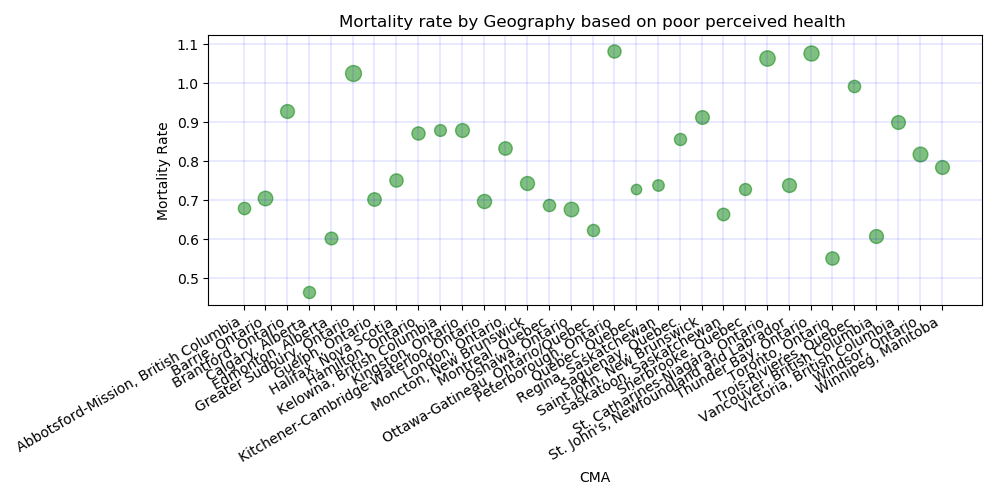

In [18]:
#Scatterplot of Mortality by City and all Poor perceived health

#Define variables
y = Final_Hospital_CMA_df['Mortality Rate']
x = Final_Hospital_CMA_df['Geography']
fig, ax = plt.subplots(figsize=(10,5))

for i in range (len(Final_Hospital_CMA_df)):
        
    #plot each dot and change the size based on Poor perceived health
    plt.scatter(x.loc[i],y.loc[i], alpha=0.50, color="green", s=Final_Hospital_CMA_df['Poor perceived health'][i]*10)
#add labels
plt.title(f"Mortality rate by Geography based on poor perceived health ")
plt.ylabel('Mortality Rate')
plt.xlabel('CMA')
fig.autofmt_xdate()   
plt.tight_layout()

#add gridlines
ax.grid(color='blue', linestyle='-', linewidth=0.25, alpha=0.5)
#Save it
plt.savefig('Hospital_Data/Mortality_Rate_Vs_Poor_perceived_health.png', bbox_inches='tight')

<IPython.core.display.Javascript object>


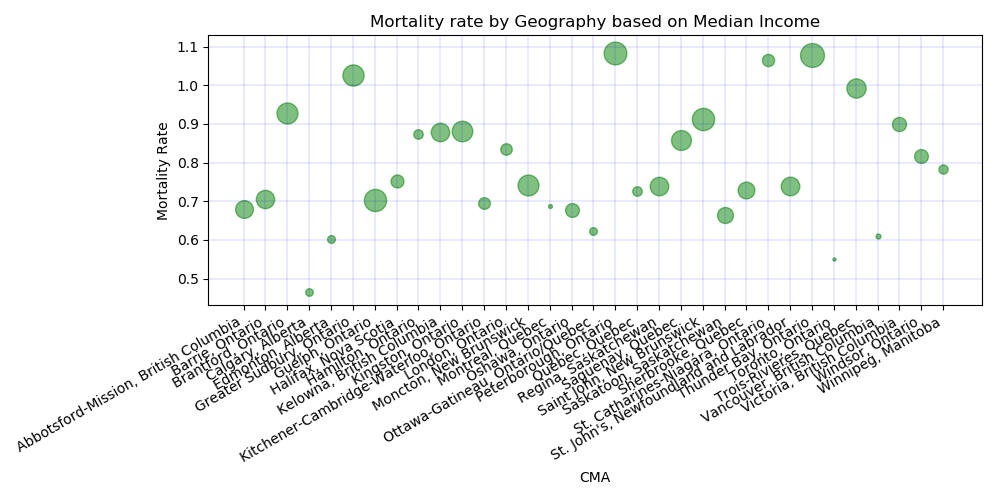

In [14]:
#Scatterplot of Mortality by City and Median Income

#Define variables
y = Final_Hospital_CMA_df['Mortality Rate']
x = Final_Hospital_CMA_df['Geography']
fig, ax = plt.subplots(figsize=(10,5))

for i in range (len(Final_Hospital_CMA_df)):
        
    #plot each dot and change the size based on Median Income
    plt.scatter(x.loc[i],y.loc[i], alpha=0.50, color="green", s=Final_Hospital_CMA_df['Median Income'][i]/Final_Hospital_CMA_df['population'][i]*1000)
#add labels
plt.title(f"Mortality rate by Geography based on Median Income")
plt.ylabel('Mortality Rate')
plt.xlabel('CMA')
fig.autofmt_xdate()   
plt.tight_layout()

#add gridlines
ax.grid(color='blue', linestyle='-', linewidth=0.25, alpha=0.5)
#Save it
plt.savefig('Hospital_Data/Mortality_Rate_Vs_Poor_Median_Income.png', bbox_inches='tight')

<IPython.core.display.Javascript object>


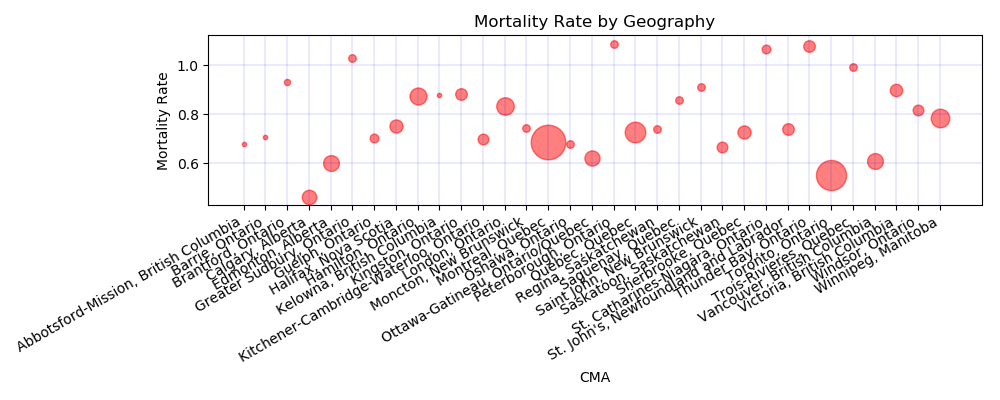

In [15]:
#Scatterplot of Mortality Rate by City based on Hospitals

#Define variables
y = Final_Hospital_CMA_df['Mortality Rate']
x = Final_Hospital_CMA_df['Geography']
fig, ax = plt.subplots(figsize=(10,4))

for i in range (len(Final_Hospital_CMA_df)):
        
    #plot each dot and change the size based on number of hospitals
    #multiplied by 10 to increase the size of the plot
    plt.scatter(x.loc[i],y.loc[i], alpha=0.50, color="red", s=Final_Hospital_CMA_df['Hospitals'][i]*10)
#add labels
plt.title(f"Mortality Rate by Geography")
plt.ylabel('Mortality Rate')
plt.xlabel('CMA')
fig.autofmt_xdate()   
plt.tight_layout()

#add gridlines
ax.grid(color='blue', linestyle='-', linewidth=0.25, alpha=0.5)
#Save it
plt.savefig('Hospital_Data/Mortality_CMA.png', bbox_inches='tight')

<IPython.core.display.Javascript object>


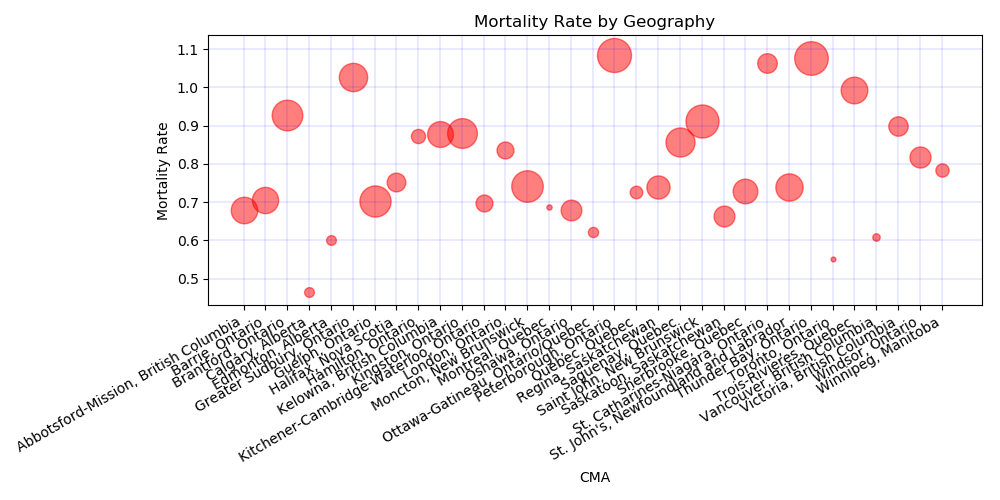

In [16]:
#Scatterplot of Mortality Rate by City based on has regular healthprovider normalizing by population

#Define variables
y = Final_Hospital_CMA_df['Mortality Rate']
x = Final_Hospital_CMA_df['Geography']
fig, ax = plt.subplots(figsize=(10,5))

for i in range (len(Final_Hospital_CMA_df)):
        
    #plot each dot and change the size based on number of hospitals
    #multiplied by 10 to increase the size of the plot
    plt.scatter(x.loc[i],y.loc[i], alpha=0.50, color="red", s=Final_Hospital_CMA_df['has regular healthprovider'][i]/Final_Hospital_CMA_df['population'][i]*1000000)
#add labels
plt.title(f"Mortality Rate by Geography")
plt.ylabel('Mortality Rate')
plt.xlabel('CMA')
fig.autofmt_xdate()   
plt.tight_layout()

#add gridlines
ax.grid(color='blue', linestyle='-', linewidth=0.25, alpha=0.5)
#Save it
plt.savefig('Hospital_Data/Mortality_CMA_regular_healthprovider.png', bbox_inches='tight')

In [17]:
### Analysis
# Maximum number of hospitals in respective cities:-
# 1. Montreal, Quebec
# 2. Toronto, Ontario
# 3. Quebec, Quebec